In [1]:
import torch, pickle, time, random, librosa
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
tqdm.pandas()

---

## Data Preprocessing

### Load Dataset Pickle

In [3]:
file = open('data-250-125.pkl', 'rb')
df = pickle.load(file)
file.close()

In [4]:
df.shape

(585900, 6)

In [18]:
df.head()

,subject,day,session,motion,repetition,window_emg
0,sub03,D3,S1,OH,1,"[[0.4140625, 0.6015625, -0.203125, -0.2109375,..."
1,sub03,D3,S1,OH,1,"[[0.2421875, -0.0546875, -0.0078125, 0.015625,..."
2,sub03,D3,S1,OH,1,"[[-0.5546875, -0.125, -0.0625, -0.0234375, -0...."
3,sub03,D3,S1,OH,1,"[[-0.1953125, -0.0625, -0.265625, -0.0234375, ..."
4,sub03,D3,S1,OH,1,"[[0.0703125, -0.1484375, 0.171875, -0.015625, ..."


### Load Hudgin Dataset

In [3]:
file = open('df_hudgin_250_125.pkl', 'rb')
df = pickle.load(file)
file.close()

### Filter only 7 Motions

In [5]:
df = df[~df.motion.isin(['IN', 'GR'])]

In [6]:
df.motion.value_counts()

motion
OH    65100
CH    65100
EX    65100
FL    65100
SU    65100
PR    65100
RT    65100
Name: count, dtype: int64

### Preprocess Labels

In [7]:
df['label'] = df.motion.replace(
    df.motion.drop_duplicates().tolist(),
    [i for i in range(7)]
)

/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_51845/480921104.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.motion.replace(


In [8]:
df.label.value_counts()

label
0    65100
1    65100
2    65100
3    65100
4    65100
5    65100
6    65100
Name: count, dtype: int64

## Fine-Tuning Architecture

### Create Model Architecture

In [9]:
class CNN(nn.Module):
    def __init__(self, input_dim=1, output_dim=7, input_height=50, input_width=8, 
                 n_conv_layers=1, n_filters=[32], conv_kernel_size=[7], 
                 pool_kernel_size=(2,1), fc2=False, dropout_rate=.5):
        super(CNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        
        # First convolutional layer
        self.conv_layers.append(nn.Conv2d(input_dim, n_filters[0], kernel_size=conv_kernel_size[0], padding='same', bias=False))
        self.bn_layers.append(nn.BatchNorm2d(n_filters[0]))
        self.pool_layers.append(nn.MaxPool2d(kernel_size=pool_kernel_size))
        
        # Additional convolutional layers
        for i in range(1, n_conv_layers):
            self.conv_layers.append(nn.Conv2d(n_filters[i-1], n_filters[i], kernel_size=conv_kernel_size[i], padding='same', bias=False))
            self.bn_layers.append(nn.BatchNorm2d(n_filters[i]))
            self.pool_layers.append(nn.MaxPool2d(kernel_size=pool_kernel_size))
        
        # Calculate the size of the feature maps after conv and pooling
        conv_height = input_height
        conv_width = input_width
        for i in range(n_conv_layers):
            conv_height = conv_height // pool_kernel_size[0]
            conv_width = conv_width // pool_kernel_size[1]
        
        self.fc_input_dim = n_filters[-1] * conv_height * conv_width
        
        self.is_fc2 = fc2
        if self.is_fc2:
            self.fc = nn.Linear(self.fc_input_dim, 256)
            self.fc2 = nn.Linear(256, output_dim)
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.fc = nn.Linear(self.fc_input_dim, output_dim)

    def forward(self, x):
        for conv, bn, pool in zip(self.conv_layers, self.bn_layers, self.pool_layers):
            x = conv(x)
            x = bn(x)
            x = F.relu(x)
            x = pool(x)
            
        x = x.view(x.size(0), -1) # Flatten the features

        if self.is_fc2:
            x = F.relu(self.fc(x))
            x = self.dropout(x)
            out = self.fc2(x)
        else:
            out = self.fc(x)
        
        return out
        

### Prepare Minimal DF

In [10]:
subjects = ['sub0' + str(i) for i in range(1, 8)]
days = ['D' + str(i) for i in range(1, 16)]
sessions = ['S1', 'S2']

sess_comb = list()

for sub in subjects:
    for day in days:
        for sess in sessions:
            for i in range(1, 11):
                sess_comb.append((sub, day, sess, i))

In [11]:
len(sess_comb)

2100

In [12]:
random.seed(42)
picked_combination = random.sample(sess_comb, 30)

In [13]:
picked_combination

[('sub02', 'D8', 'S2', 7),
 ('sub01', 'D6', 'S1', 3),
 ('sub04', 'D12', 'S1', 7),
 ('sub04', 'D6', 'S1', 4),
 ('sub04', 'D1', 'S2', 5),
 ('sub02', 'D14', 'S2', 2),
 ('sub02', 'D6', 'S2', 10),
 ('sub02', 'D3', 'S2', 7),
 ('sub06', 'D12', 'S1', 9),
 ('sub01', 'D7', 'S2', 1),
 ('sub01', 'D7', 'S1', 3),
 ('sub02', 'D5', 'S1', 4),
 ('sub03', 'D15', 'S2', 6),
 ('sub04', 'D3', 'S2', 3),
 ('sub07', 'D14', 'S1', 10),
 ('sub01', 'D6', 'S1', 9),
 ('sub03', 'D11', 'S2', 5),
 ('sub06', 'D11', 'S2', 9),
 ('sub04', 'D1', 'S1', 3),
 ('sub07', 'D2', 'S2', 10),
 ('sub04', 'D12', 'S2', 10),
 ('sub01', 'D2', 'S1', 7),
 ('sub03', 'D3', 'S2', 4),
 ('sub06', 'D12', 'S2', 2),
 ('sub05', 'D10', 'S2', 4),
 ('sub04', 'D12', 'S2', 9),
 ('sub03', 'D2', 'S2', 7),
 ('sub03', 'D15', 'S1', 2),
 ('sub05', 'D9', 'S2', 9),
 ('sub02', 'D6', 'S2', 9)]

In [35]:
df[(df.subject == 'sub01') & (df.day == 'D1') & (df.session == 'S1') & (df.repetition != 1)]

,subject,day,session,motion,repetition,window_emg,label
474331,sub01,D1,S1,OH,2,"[[0.0, 0.0078125, 0.0078125, 0.046875, 0.16406...",0
474332,sub01,D1,S1,OH,2,"[[-0.0078125, -0.015625, 0.0, 0.015625, 0.1093...",0
474333,sub01,D1,S1,OH,2,"[[0.0, 0.0, 0.0, 0.0078125, -0.1328125, 0.0234...",0
474334,sub01,D1,S1,OH,2,"[[0.03125, 0.0, 0.0, 0.0, 0.03125, -0.015625, ...",0
474335,sub01,D1,S1,OH,2,"[[0.0, -0.0078125, -0.03125, -0.078125, -0.070...",0
...,...,...,...,...,...,...,...
477085,sub01,D1,S1,RT,10,"[[-0.015625, -0.0078125, -0.0078125, -0.007812...",6
477086,sub01,D1,S1,RT,10,"[[-0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, -0.00781...",6
477087,sub01,D1,S1,RT,10,"[[-0.0078125, 0.0, 0.0, 0.0, 0.0078125, 0.0156...",6
477088,sub01,D1,S1,RT,10,"[[-0.0078125, -0.0078125, 0.0, 0.0, 0.0625, 0....",6


In [14]:
def prepare_training(train_df, test_df, shape=(50,8), specgram=False):
    device = 'mps'

    if specgram:
        X1_train = torch.FloatTensor(np.stack(train_df.specgram.to_numpy()).reshape(-1, 1, shape[0], shape[1])).to(device)
        X1_test = torch.FloatTensor(np.stack(test_df.specgram.to_numpy()).reshape(-1, 1, shape[0], shape[1])).to(device)
    else:
        X1_train = torch.FloatTensor(np.stack(train_df.window_emg.to_numpy()).reshape(-1, 1, shape[0], shape[1])).to(device)
        X1_test = torch.FloatTensor(np.stack(test_df.window_emg.to_numpy()).reshape(-1, 1, shape[0], shape[1])).to(device)
    y1_train = torch.FloatTensor(train_df.label.to_numpy()).to(device)
    y1_test = torch.FloatTensor(test_df.label.to_numpy()).to(device)

    train_set = TensorDataset(X1_train, y1_train)
    val_set = TensorDataset(X1_test, y1_test)

    return train_set, val_set

In [26]:
def featurize(data):
    """
    Concatenate MAV, WL, SSC, and ZC features into a long list of features
    """
    features = None

    # Concatenate all relevant features
    for f in ['mav', 'wl', 'ssc', 'zc']:
        if type(features) != type(None):
            features = np.concatenate([features, np.vstack(data[f])], axis=1)
        else:
            features = np.vstack(data[f])

    return features

### Test on LDA

In [39]:
accuracies = list()

for sub, day, sess, rep in picked_combination:
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    X_train = featurize(df_train)
    X_test = featurize(df_test)
    y_train = df_train.label.to_numpy()
    y_test = df_test.label.to_numpy()

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)

    y_pred = lda.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    accuracies.append(acc)
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Accuracy {acc:.2f}%')
    

Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Accuracy 99.54%
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Accuracy 99.54%
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Accuracy 100.00%
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Accuracy 95.85%
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Accuracy 100.00%
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Accuracy 89.40%
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Accuracy 92.63%
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Accuracy 90.78%
Subject sub06 | Day D12 | Session S1 | Test Repetition 9 | Accuracy 92.63%
Subject sub01 | Day D7 | Session S2 | Test Repetition 1 | Accuracy 89.40%
Subject sub01 | Day D7 | Session S1 | Test Repetition 3 | Accuracy 97.70%
Subject sub02 | Day D5 | Session S1 | Test Repetition 4 | Accuracy 96.77%
Subject sub03 | Day D15 | Session S2 | Test Repetition 6 | Accuracy 99.54%
Subject sub04 | Day D3 | Sessio

In [40]:
len(accuracies)

30

In [41]:
np.mean(accuracies)

95.14592933947772

### Create Interpolated Input

In [19]:
def interpolate_emg(emg_data, target_channels=80):
    num_points, num_channels = emg_data.shape

    # Create the original x-axis (channel numbers)
    x_original = np.arange(num_channels)

    # Create the new x-axis for interpolation
    x_new = np.linspace(0, num_channels - 1, target_channels)

    # Initialize the interpolated data array
    interpolated_data = np.zeros((num_points, target_channels))

    # Perform spline interpolation for each time point
    for i in range(num_points):
        # Create a spline interpolation function for the current time point
        spline = InterpolatedUnivariateSpline(x_original, emg_data[i, :])
        
        # Interpolate the data for the new x-axis
        interpolated_data[i, :] = spline(x_new)

    return interpolated_data

In [20]:
a = interpolate_emg(df.window_emg[454064])

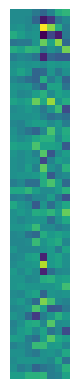

In [24]:
plt.imshow(df.window_emg[454064]);
plt.axis('off');

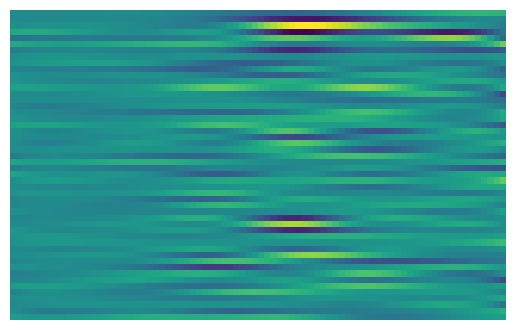

In [25]:
plt.imshow(a);
plt.axis('off');

### Create Spectrogram Input

In [360]:
def emg_to_lms(emg, fs=200, n_fft=32, hop_length=24):
    lms_list = list()
    
    for i in range(8):
        mel_spec = librosa.feature.melspectrogram(y=emg[:, i], sr=fs, n_fft=n_fft, hop_length=hop_length)
        lms = librosa.power_to_db(mel_spec)
        lms_list.append(lms)

    com_lms = np.hstack(lms_list)
    
    return com_lms

In [361]:
c = emg_to_lms(b)

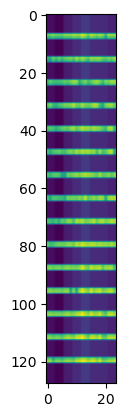

In [362]:
plt.imshow(c)

In [26]:
def librosa_specgram(y, nfft=16, hop=8):
    specgram_list = list()
    
    for i in range(8):
        D = librosa.stft(y[:, i], n_fft=nfft, hop_length=hop, window='hann')
        S = np.abs(D)**2
        specgram_list.append(librosa.power_to_db(S, ref=np.max))

    com_spec = np.hstack(specgram_list)
    
    # Replace infinities
    min_non_inf = com_spec[~np.isinf(com_spec)].min()
    com_spec[np.isinf(com_spec)] =  min_non_inf

    # # Normalise data
    min_val = com_spec.min()
    max_val = com_spec.max()
    com_spec = (com_spec - min_val) / (max_val - min_val)
    
    return com_spec

In [27]:
c = librosa_specgram(a)

In [31]:
c.shape

(9, 56)

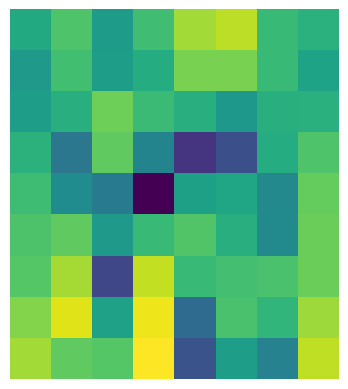

In [33]:
plt.imshow(c[:,:8]);
plt.axis('off');

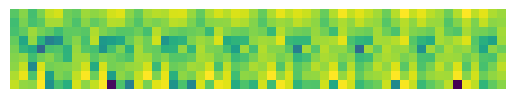

In [32]:
plt.imshow(c);
plt.axis('off');

In [301]:
def convert_specgram(emg, fs=200):
    specgram_list = list()
    
    for i in range(8):
        _, _, _, im = plt.specgram(emg[:, i], Fs=fs, NFFT=16, noverlap=8)
        plt.close()
        im =  im.get_array().data
        specgram_list.append(im)

    com_spec = np.hstack(specgram_list)

    # Replace infinities
    min_non_inf = com_spec[~np.isinf(com_spec)].min()
    com_spec[np.isinf(com_spec)] =  min_non_inf

    # # Normalise data
    min_val = com_spec.min()
    max_val = com_spec.max()
    com_spec = (com_spec - min_val) / (max_val - min_val)
    
    return com_spec

In [316]:
convert_specgram(b).shape

(9, 40)

In [372]:
df['specgram'] = df.window_emg.progress_apply(librosa_specgram)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455700/455700 [10:40<00:00, 711.67it/s]


In [350]:
b = df.window_emg[454064]

In [344]:
b = convert_specgram(b)

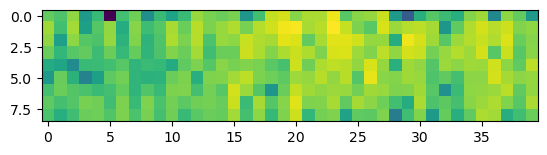

In [345]:
plt.imshow(b)

### Create Training Loop Function

In [15]:
def train_model(model, train_set, val_set, criterion, optimizer, num_epochs=50, batch_size=64, verbose=True):
    device = 'mps'
    model.to(device)
    train_loader = DataLoader(train_set, batch_size=batch_size)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    train_loss = list()
    train_acc = list()
    val_loss = list()
    val_acc = list()
    train_times = list()
    inf_times = list()

    for epoch in range(num_epochs):
        start_epoch = time.time()
        model.train()
        train_total_loss = 0
        total = 0
        correct = 0

        start = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()
        ttime = (time.time() - start) * 1e6 # in microsecond
        train_times.append(ttime)

        # Keep tab on the train loss every epoch
        train_loss.append(train_total_loss / len(train_loader))
        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        model.eval()
        correct = 0
        total = 0
        val_total_loss = 0

        start = time.time()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        itime = (time.time() - start) * 1e6 # in microsecond
        inf_times.append(itime)

        val_loss.append(val_total_loss / len(val_loader))

        val_accuracy = 100 * correct / total
        val_acc.append(val_accuracy)

        if verbose:
            etime = (time.time() - start_epoch) * 1e3
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Epoch Time: {etime:.4f}ms')
        
    avg_train_time = np.mean(train_times)
    avg_inf_time = np.mean(inf_times)

    return model, train_loss, train_acc, val_loss, val_acc, avg_train_time, avg_inf_time

### Architecture 1: Layer=1, Kernel=3, Filter=32

LR 0.1 Epoch 50

In [122]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 16190.9759ms | Accuracy 14.29%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 16392.9291ms | Accuracy 16.13%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 16425.8072ms | Accuracy 15.21%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 16539.4781ms | Accuracy 21.20%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 16087.6698ms | Accuracy 14.29%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 16425.6039ms | Accuracy 14.29%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 16460.1161ms | Accuracy 16.59%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1636

LR 0.01 Epoch 50

In [123]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15794.1959ms | Accuracy 93.09%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 16521.0910ms | Accuracy 96.77%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 16698.5941ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 16571.8760ms | Accuracy 95.85%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15806.7529ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 16099.9320ms | Accuracy 88.48%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 16556.0899ms | Accuracy 84.33%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 163

LR 0.001 Epoch 15

In [73]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4305.0852ms | Accuracy 89.40%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4287.5080ms | Accuracy 89.86%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4241.0808ms | Accuracy 91.71%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4251.9491ms | Accuracy 85.71%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4102.7462ms | Accuracy 99.08%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 3981.3240ms | Accuracy 87.56%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4352.3216ms | Accuracy 81.57%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4351.5899ms

LR 0.001 Epoch 50

In [124]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 16161.6910ms | Accuracy 95.39%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 16308.1741ms | Accuracy 93.09%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 16114.5971ms | Accuracy 92.63%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 16495.1150ms | Accuracy 94.47%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 16553.4101ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 16470.9051ms | Accuracy 91.24%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 16398.4330ms | Accuracy 86.64%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 161

LR 0.0001 Epoch 50

In [125]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 16251.1199ms | Accuracy 93.55%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15102.9708ms | Accuracy 95.39%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 15284.4632ms | Accuracy 99.54%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 16329.9441ms | Accuracy 91.71%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 16811.0161ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 16663.5399ms | Accuracy 92.63%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15640.3332ms | Accuracy 86.18%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 162

LR 0.00005 Epoch 50

In [126]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15970.6960ms | Accuracy 93.09%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 16294.0359ms | Accuracy 95.39%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 15643.0168ms | Accuracy 99.54%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15634.7039ms | Accuracy 92.63%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15793.7341ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15572.4242ms | Accuracy 91.71%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15578.7821ms | Accuracy 89.86%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 154

LR 0.00001 Epoch 50

In [127]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15506.9532ms | Accuracy 93.09%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15829.7360ms | Accuracy 95.39%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 16156.8022ms | Accuracy 98.16%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15204.5341ms | Accuracy 92.17%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15955.8439ms | Accuracy 99.08%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 16022.8722ms | Accuracy 83.41%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15889.8699ms | Accuracy 85.71%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1585

### Input 2: Interpolated EMG

In [74]:
input_dim = 1
n_classes = 7
input_height = 50
input_width = 80
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Interpolate EMG
    df_train.window_emg = df_train.window_emg.apply(lambda x: interpolate_emg(x))
    df_test.window_emg = df_test.window_emg.apply(lambda x: interpolate_emg(x))

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test, shape=(50, 80))

    # Prepare training
    model = CNN(input_dim, n_classes, input_height, input_width,n_conv_layers=n_conv_layers, 
                conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1


/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_18708/77970591.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.window_emg = df_train.window_emg.apply(lambda x: interpolate_emg(x))
/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_18708/77970591.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.window_emg = df_test.window_emg.apply(lambda x: interpolate_emg(x))


Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 6944.9508ms | Accuracy 77.88%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 6796.8719ms | Accuracy 61.29%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 6890.1911ms | Accuracy 88.02%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 7039.3028ms | Accuracy 76.04%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 6730.1371ms | Accuracy 83.41%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 6615.3400ms | Accuracy 78.34%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 6794.3630ms | Accuracy 76.50%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 6807.0970ms | Accuracy 78.80%
Start trainin

### Input 3: Transposed Input

In [75]:
input_dim = 1
n_classes = 7
input_height = 8
input_width = 50
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]
pool_kernel_size = (1, 2)

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Transpose EMG
    df_train.window_emg = df_train.window_emg.apply(lambda x: x.T)
    df_test.window_emg = df_test.window_emg.apply(lambda x: x.T)

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test, shape=(input_height, input_width))

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters, pool_kernel_size=pool_kernel_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1


/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_18708/656307846.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.window_emg = df_train.window_emg.apply(lambda x: x.T)
/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_18708/656307846.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.window_emg = df_test.window_emg.apply(lambda x: x.T)


Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 3779.6512ms | Accuracy 88.02%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 3981.7023ms | Accuracy 90.78%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 3743.2482ms | Accuracy 92.17%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 3792.2680ms | Accuracy 87.10%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 3690.1131ms | Accuracy 99.54%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 3983.3419ms | Accuracy 85.25%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 3963.4302ms | Accuracy 81.57%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 3787.8280ms | Accuracy 83.87%
Start trainin

### Input 4: 0-Centered

In [76]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # 0-Center EMG
    df_train.window_emg = df_train.window_emg.apply(lambda x: x - x.mean(axis=0))
    df_test.window_emg = df_test.window_emg.apply(lambda x: x - x.mean(axis=0))

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1


/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_18708/1246409595.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.window_emg = df_train.window_emg.apply(lambda x: x - x.mean(axis=0))
/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_18708/1246409595.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.window_emg = df_test.window_emg.apply(lambda x: x - x.mean(axis=0))


Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4308.0151ms | Accuracy 87.10%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 3989.3799ms | Accuracy 86.18%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4114.6610ms | Accuracy 86.18%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4222.1639ms | Accuracy 69.12%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4182.1158ms | Accuracy 96.77%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4099.6311ms | Accuracy 87.10%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4065.4771ms | Accuracy 83.41%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 3798.2306ms | Accuracy 83.41%
Start trainin

### Input 5: Spectrogram

In [375]:
df.loc[0].specgram.shape

(9, 56)

In [379]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]
pool_kernel_size = (1, 2)

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test, shape=(9, 56), specgram=True)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, input_height=9, input_width=56,
                conv_kernel_size=conv_kernel_size, n_filters=n_filters, pool_kernel_size=pool_kernel_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4752.1129ms | Accuracy 53.92%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4147.3079ms | Accuracy 65.90%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4360.5230ms | Accuracy 84.79%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4597.2800ms | Accuracy 79.72%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4301.8517ms | Accuracy 84.33%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4596.6163ms | Accuracy 69.59%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4756.5422ms | Accuracy 54.84%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4657.0890ms

### Input 6: Normalized

In [18]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]
pool_kernel_size = (1, 2)

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # 0-Center EMG
    df_train.window_emg = df_train.window_emg.apply(lambda x: (x - x.mean(axis=0)) / np.std(x))
    df_test.window_emg = df_test.window_emg.apply(lambda x: (x - x.mean(axis=0)) / np.std(x))

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters, pool_kernel_size=pool_kernel_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1


/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_51845/1771584089.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.window_emg = df_train.window_emg.apply(lambda x: (x - x.mean(axis=0)) / np.std(x))
/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_51845/1771584089.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.window_emg = df_test.window_emg.apply(lambda x: (x - x.mean(axis=0)) / np.std(x))


Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 8385.5860ms | Accuracy 94.93%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 8405.5171ms | Accuracy 96.77%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 8958.6439ms | Accuracy 97.70%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 8553.2250ms | Accuracy 94.93%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 8655.0632ms | Accuracy 99.54%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 8645.0408ms | Accuracy 85.71%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 8656.8110ms | Accuracy 81.57%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 8723.1271ms | Accuracy 80.18%
Start trainin

In [ ]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]
pool_kernel_size = (1, 2)

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # 0-Center EMG
    df_train.window_emg = df_train.window_emg.apply(lambda x: (x - x.mean(axis=0)) / np.std(x))
    df_test.window_emg = df_test.window_emg.apply(lambda x: (x - x.mean(axis=0)) / np.std(x))

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters, pool_kernel_size=pool_kernel_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

### Architecture 2: Layer=2, Kernel=3, Filter=[32, 64]

LR 0.1

In [117]:
n_conv_layers = 2
conv_kernel_size = [3, 3]
n_filters = [32, 64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 14646.5971ms | Accuracy 20.74%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 14858.7658ms | Accuracy 14.29%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 14700.8390ms | Accuracy 14.29%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 14646.9202ms | Accuracy 14.29%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 14992.6689ms | Accuracy 14.75%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 14540.2241ms | Accuracy 14.75%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 14328.0189ms | Accuracy 26.73%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1499

LR 0.01

In [118]:
n_conv_layers = 2
conv_kernel_size = [3, 3]
n_filters = [32, 64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 14740.7861ms | Accuracy 79.72%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 14897.7869ms | Accuracy 88.02%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 14520.9479ms | Accuracy 85.25%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15479.0301ms | Accuracy 74.19%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 14905.0980ms | Accuracy 85.25%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15016.6039ms | Accuracy 64.98%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15125.7730ms | Accuracy 53.46%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1587

LR 0.001

In [83]:
n_conv_layers = 2
conv_kernel_size = [3, 3]
n_filters = [32, 64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4450.6743ms | Accuracy 81.57%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4321.9671ms | Accuracy 83.87%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4393.8041ms | Accuracy 92.17%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4301.1069ms | Accuracy 64.52%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4126.2009ms | Accuracy 95.85%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4278.4302ms | Accuracy 71.43%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4235.7771ms | Accuracy 63.59%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4280.3662ms

LR 0.0001

In [119]:
n_conv_layers = 2
conv_kernel_size = [3, 3]
n_filters = [32, 64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15071.4979ms | Accuracy 84.79%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 14853.0171ms | Accuracy 96.31%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 15017.6771ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15138.4342ms | Accuracy 97.24%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15266.1791ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15120.8210ms | Accuracy 88.48%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15275.7680ms | Accuracy 77.42%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 153

LR 0.00005

In [120]:
n_conv_layers = 2
conv_kernel_size = [3, 3]
n_filters = [32, 64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15101.5191ms | Accuracy 85.25%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15352.8242ms | Accuracy 84.33%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 14826.1282ms | Accuracy 97.70%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15774.3952ms | Accuracy 94.93%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15238.0412ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15536.1772ms | Accuracy 88.02%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15610.1980ms | Accuracy 76.96%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 153

LR 0.00001

In [121]:
n_conv_layers = 2
conv_kernel_size = [3, 3]
n_filters = [32, 64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15264.3869ms | Accuracy 90.78%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 14981.3862ms | Accuracy 79.72%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 14934.4869ms | Accuracy 94.47%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15137.2640ms | Accuracy 83.87%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15128.1950ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15126.5972ms | Accuracy 81.11%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15045.6679ms | Accuracy 75.12%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 148

### Architecture 3: Layer=3, Kernel=3, Filter=[32, 64, 128], Pool=(2, 1)

LR 0.1

In [114]:
n_conv_layers = 3
conv_kernel_size = [3, 3, 3]
n_filters = [32, 64, 128]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15636.3730ms | Accuracy 14.29%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15770.0522ms | Accuracy 14.29%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 15611.8999ms | Accuracy 14.29%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15644.4693ms | Accuracy 14.29%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15654.0859ms | Accuracy 14.75%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15787.0131ms | Accuracy 14.75%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15610.3711ms | Accuracy 19.35%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1571

LR 0.01

In [112]:
n_conv_layers = 3
conv_kernel_size = [3, 3, 3]
n_filters = [32, 64, 128]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15775.1691ms | Accuracy 14.29%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15662.3728ms | Accuracy 70.51%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 15846.6361ms | Accuracy 77.88%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15700.3489ms | Accuracy 77.42%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15745.0538ms | Accuracy 84.33%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15696.5728ms | Accuracy 73.73%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15715.0469ms | Accuracy 23.96%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1566

LR 0.001

In [111]:
n_conv_layers = 3
conv_kernel_size = [3, 3, 3]
n_filters = [32, 64, 128]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 16192.1012ms | Accuracy 71.43%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15931.0701ms | Accuracy 88.02%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 15954.6599ms | Accuracy 82.95%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15636.8277ms | Accuracy 90.32%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15709.6503ms | Accuracy 84.33%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15685.9350ms | Accuracy 71.89%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15977.8707ms | Accuracy 73.27%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1579

LR 0.0001

In [31]:
n_conv_layers = 3
conv_kernel_size = [3, 3, 3]
n_filters = [32, 64, 128]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 9478.5910ms | Accuracy 96.31%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 9343.0882ms | Accuracy 85.71%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 9257.0179ms | Accuracy 99.54%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 9212.4152ms | Accuracy 94.93%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 9061.7940ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 9364.5782ms | Accuracy 77.88%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 9388.2182ms | Accuracy 83.41%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 9210.2737m

LR 0.00005

In [110]:
n_conv_layers = 3
conv_kernel_size = [3, 3, 3]
n_filters = [32, 64, 128]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 16364.4652ms | Accuracy 92.63%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15832.3238ms | Accuracy 94.01%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 15874.1021ms | Accuracy 99.54%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 16083.5409ms | Accuracy 98.16%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 16274.5390ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 16100.9140ms | Accuracy 75.58%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 16156.2431ms | Accuracy 75.12%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 163

LR 0.00001

In [115]:
n_conv_layers = 3
conv_kernel_size = [3, 3, 3]
n_filters = [32, 64, 128]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 16023.0792ms | Accuracy 89.86%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15708.7181ms | Accuracy 83.87%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 16697.7720ms | Accuracy 93.09%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 16158.8352ms | Accuracy 94.01%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 16124.6312ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 16689.2509ms | Accuracy 84.79%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 16555.7799ms | Accuracy 74.65%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 160

### Architecture 4: Layer=1, Kernel=3, Filter=[16], Pool=[2,1]

In [88]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [16]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 3599.8800ms | Accuracy 90.32%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4283.6473ms | Accuracy 88.94%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 3674.6478ms | Accuracy 90.78%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 3612.0749ms | Accuracy 76.96%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 3525.0707ms | Accuracy 97.70%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 3539.7182ms | Accuracy 87.56%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 3353.9422ms | Accuracy 79.72%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4024.7731ms

### Architecture 5: Layer=1, Kernel=3, Filter=[64], Pool=(2, 1)

Epoch 15

In [89]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4998.1298ms | Accuracy 87.56%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4689.2011ms | Accuracy 85.71%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4739.3711ms | Accuracy 89.86%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4777.0991ms | Accuracy 86.64%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4924.0141ms | Accuracy 96.31%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4949.4269ms | Accuracy 86.64%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 5001.4679ms | Accuracy 81.11%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4970.5729ms

Epoch 50

In [380]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 16820.7850ms | Accuracy 91.24%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 18193.6200ms | Accuracy 88.48%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 17924.4449ms | Accuracy 90.78%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 17895.1371ms | Accuracy 90.78%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 17413.9199ms | Accuracy 98.16%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 17780.6742ms | Accuracy 88.48%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 18522.9640ms | Accuracy 85.71%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1805

### Architecture 6: Layer=1, Kernel=3, Filter=128, Pool=(2,1)

In [90]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [128]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4954.8898ms | Accuracy 81.57%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 5130.7499ms | Accuracy 85.71%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4980.8347ms | Accuracy 90.32%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 5120.7302ms | Accuracy 89.40%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 5104.9521ms | Accuracy 97.24%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 5084.9023ms | Accuracy 86.18%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 5033.4899ms | Accuracy 78.80%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 5073.4992ms

### Architecture 7: Layer=3, Kernel=3, Filter=[32], Pool=(2,1), FC2=True

In [91]:
n_conv_layers = 1
conv_kernel_size = [3]
n_filters = [32]
fc2 = True

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters, fc2=fc2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 5047.8139ms | Accuracy 14.29%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4081.3172ms | Accuracy 29.95%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4141.3920ms | Accuracy 33.64%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4065.7201ms | Accuracy 42.40%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4035.5480ms | Accuracy 28.57%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4088.7930ms | Accuracy 14.29%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4204.4861ms | Accuracy 14.29%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4016.3312ms

### Architecture 8: Layer=1, Kernel=5, Filter=[32], Pool=(2, 1)

In [92]:
n_conv_layers = 1
conv_kernel_size = [5]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4287.0808ms | Accuracy 91.24%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4286.3200ms | Accuracy 92.63%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4096.5071ms | Accuracy 93.09%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4222.8110ms | Accuracy 84.79%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4174.1109ms | Accuracy 99.08%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4248.7569ms | Accuracy 85.25%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4253.2070ms | Accuracy 82.49%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4178.6079ms

### Architecture 9: Layer=1, Kernel=1, Filter=32, Pool=(2, 1)

In [93]:
n_conv_layers = 1
conv_kernel_size = [1]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4218.3230ms | Accuracy 82.95%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4528.1301ms | Accuracy 85.25%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4193.0840ms | Accuracy 82.49%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4430.2931ms | Accuracy 73.27%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4433.5198ms | Accuracy 96.77%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4373.9252ms | Accuracy 91.71%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4341.2349ms | Accuracy 87.56%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4442.5187ms

### Architecture 10: Layer=1, Kernel=7, filter=32

In [382]:
n_conv_layers = 1
conv_kernel_size = [7]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4579.8261ms | Accuracy 93.09%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4807.4031ms | Accuracy 84.33%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4739.3689ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4745.2562ms | Accuracy 94.01%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4682.4720ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4750.3231ms | Accuracy 85.71%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4702.3561ms | Accuracy 84.33%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4776.3848m

### Architecture 11: Layer=2, Kernel=5, Filter=32

In [98]:
n_conv_layers = 2
conv_kernel_size = [5, 3]
n_filters = [32, 64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4839.5059ms | Accuracy 77.88%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4834.2052ms | Accuracy 66.82%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4694.7131ms | Accuracy 96.31%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4760.4151ms | Accuracy 80.18%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4702.1019ms | Accuracy 86.18%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4818.7389ms | Accuracy 70.51%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4610.0962ms | Accuracy 61.29%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4713.0880ms

### Architecture 12: Layer=1, Kernel=7, Filter=32, Pool=(3,1)

In [387]:
n_conv_layers = 1
conv_kernel_size = [7]
n_filters = [32]
pool_kernel_size = (3,1)

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, 
                n_filters=n_filters, pool_kernel_size=pool_kernel_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4890.4660ms | Accuracy 96.31%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4742.1131ms | Accuracy 87.56%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4543.4451ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4627.3680ms | Accuracy 91.71%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4718.1671ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4749.8860ms | Accuracy 84.79%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4549.5260ms | Accuracy 85.71%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4660.8799

### Architecture 13: Layer=1, Kernel=7, Filter=32, Pool=(4,1)

In [386]:
n_conv_layers = 1
conv_kernel_size = [7]
n_filters = [32]
pool_kernel_size = (4,1)

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, 
                n_filters=n_filters, pool_kernel_size=pool_kernel_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4765.7089ms | Accuracy 94.93%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4642.9570ms | Accuracy 85.71%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4647.4299ms | Accuracy 99.54%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4319.8299ms | Accuracy 85.25%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4610.2161ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4749.2650ms | Accuracy 82.95%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4926.2331ms | Accuracy 91.71%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4851.1331m

### Layer=2, Kernel=7, Filter=[32, 64]

In [459]:
n_conv_layers = 2
conv_kernel_size = [7, 7]
n_filters = [32, 64]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, 
                n_filters=n_filters, pool_kernel_size=pool_kernel_size, fc2=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 9207.2990ms | Accuracy 99.08%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 8844.0499ms | Accuracy 90.32%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 8850.3480ms | Accuracy 85.71%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 9067.9002ms | Accuracy 85.25%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 9251.5671ms | Accuracy 99.54%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 8741.7281ms | Accuracy 72.81%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 8852.8142ms | Accuracy 76.50%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 9243.4738ms

## Hyperparameter Tuning

### Architecture 10 + Optim SGD

Epoch 15

In [389]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4699.1572ms | Accuracy 81.11%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4736.1460ms | Accuracy 71.89%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4645.1747ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4729.6929ms | Accuracy 87.56%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4615.6521ms | Accuracy 78.34%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4436.4700ms | Accuracy 77.88%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4694.2179ms | Accuracy 65.90%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4525.0597ms

In [34]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15, batch_size=32)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4514.5380ms | Accuracy 60.83%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4490.9489ms | Accuracy 75.58%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4588.9299ms | Accuracy 97.24%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4763.3111ms | Accuracy 74.65%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4657.1174ms | Accuracy 84.79%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4587.0719ms | Accuracy 75.58%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4722.3032ms | Accuracy 68.66%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4652.4780ms

Epoch 50

In [390]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 15890.8198ms | Accuracy 90.32%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 15891.3438ms | Accuracy 88.48%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 15595.3557ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 15910.8799ms | Accuracy 88.02%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 15247.2918ms | Accuracy 98.62%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 15592.5312ms | Accuracy 88.48%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 15712.5981ms | Accuracy 85.71%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1561

In [104]:
n_conv_layers = 1
conv_kernel_size = [5]
n_filters = [32]

accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN(n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4762.5282ms | Accuracy 15.67%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4590.9817ms | Accuracy 27.65%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4476.9421ms | Accuracy 21.20%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4512.6920ms | Accuracy 21.20%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4554.4329ms | Accuracy 26.73%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4566.9541ms | Accuracy 22.12%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4445.8008ms | Accuracy 25.35%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4524.8842ms

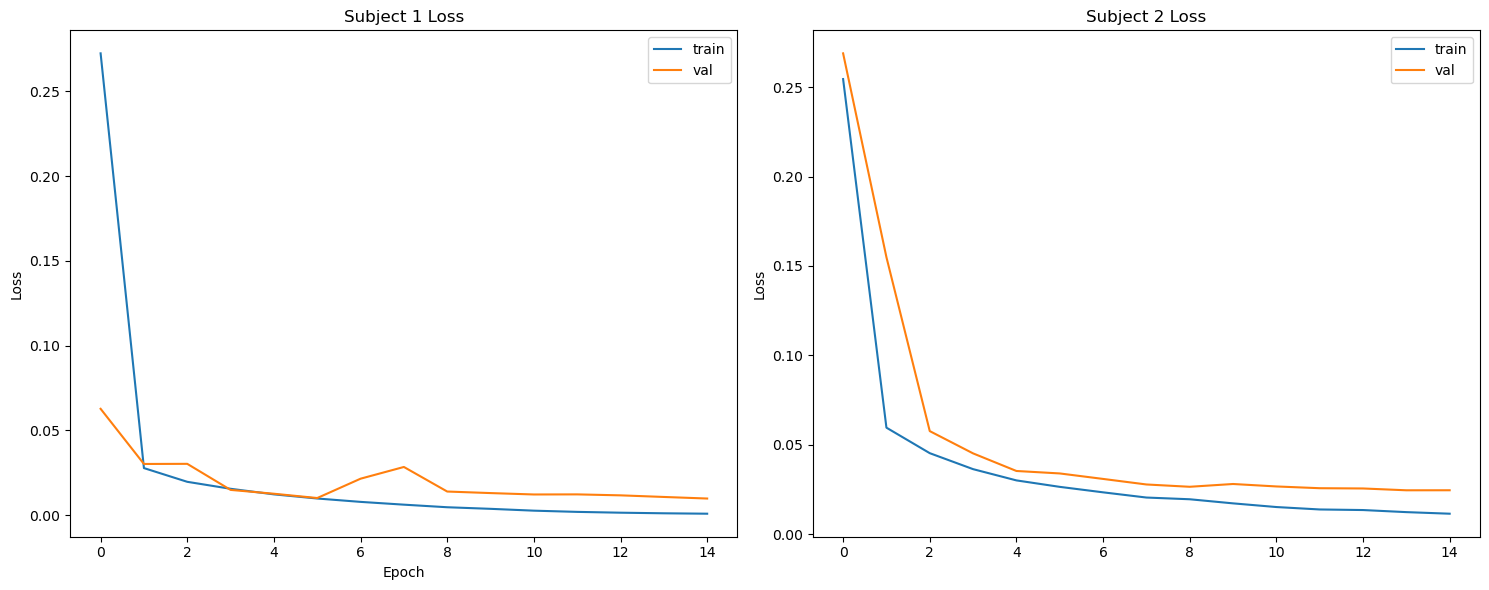

In [106]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

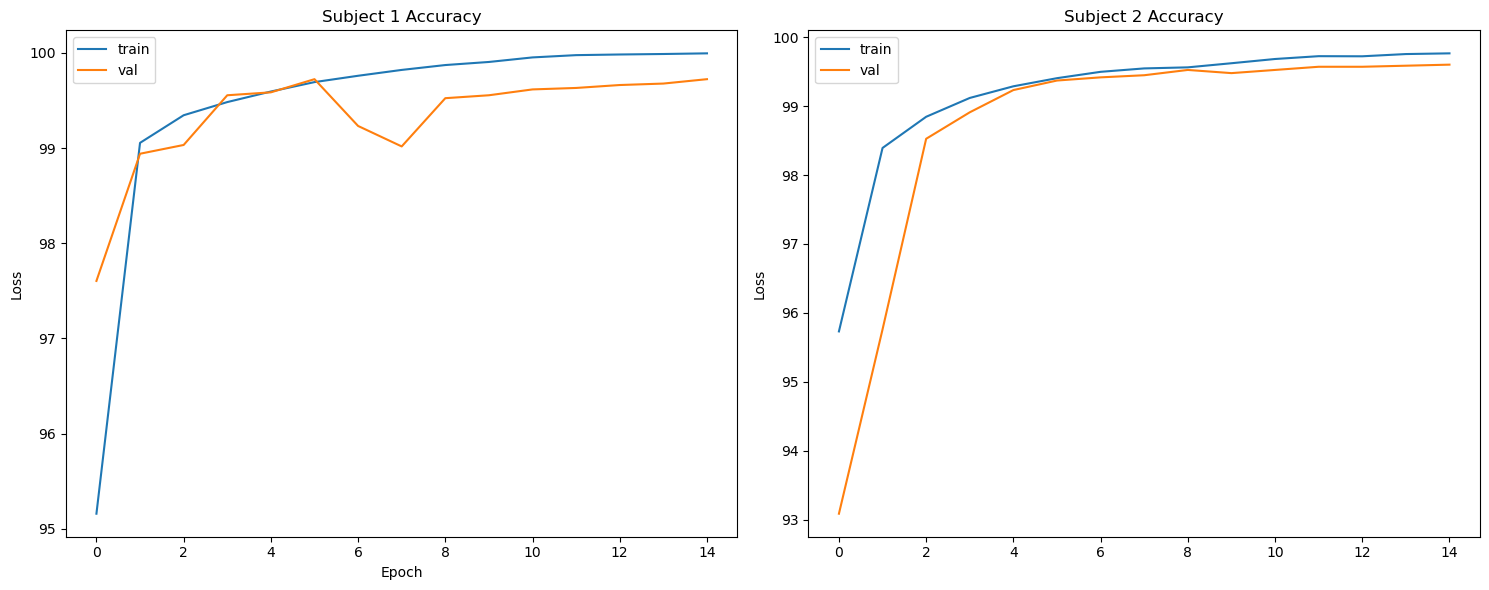

In [107]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [108]:
input_dim = 1
n_classes = 7
input_height = 50
input_width = 8
n_conv_layers = 3
conv_kernel_size = [3, 3, 3]
n_filters = [32, 64, 128]
pool_kernel_size = (2, 1)

print('Training on Subject 1')
print('=====================')
model1 = CNN(input_dim, n_classes, input_height, input_width,
             n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters, pool_kernel_size=pool_kernel_size)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0., weight_decay=0.)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = CNN(input_dim, n_classes, input_height, input_width,
             n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters, pool_kernel_size=pool_kernel_size)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0., weight_decay=0.)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 95.71%, Validation Accuracy: 97.53%, Epoch Time: 4426.3961ms
Epoch [2/15], Train Accuracy: 98.70%, Validation Accuracy: 98.26%, Epoch Time: 4031.8773ms
Epoch [3/15], Train Accuracy: 99.10%, Validation Accuracy: 98.76%, Epoch Time: 4017.7052ms
Epoch [4/15], Train Accuracy: 99.30%, Validation Accuracy: 98.96%, Epoch Time: 4057.2028ms
Epoch [5/15], Train Accuracy: 99.46%, Validation Accuracy: 99.12%, Epoch Time: 4290.1151ms
Epoch [6/15], Train Accuracy: 99.57%, Validation Accuracy: 99.26%, Epoch Time: 4248.2669ms
Epoch [7/15], Train Accuracy: 99.67%, Validation Accuracy: 99.34%, Epoch Time: 3988.4181ms
Epoch [8/15], Train Accuracy: 99.74%, Validation Accuracy: 99.40%, Epoch Time: 3972.5771ms
Epoch [9/15], Train Accuracy: 99.79%, Validation Accuracy: 99.49%, Epoch Time: 3987.3638ms
Epoch [10/15], Train Accuracy: 99.82%, Validation Accuracy: 99.54%, Epoch Time: 3990.0129ms
Epoch [11/15], Train Accuracy: 99.86%, Validation Accuracy: 99.57%,

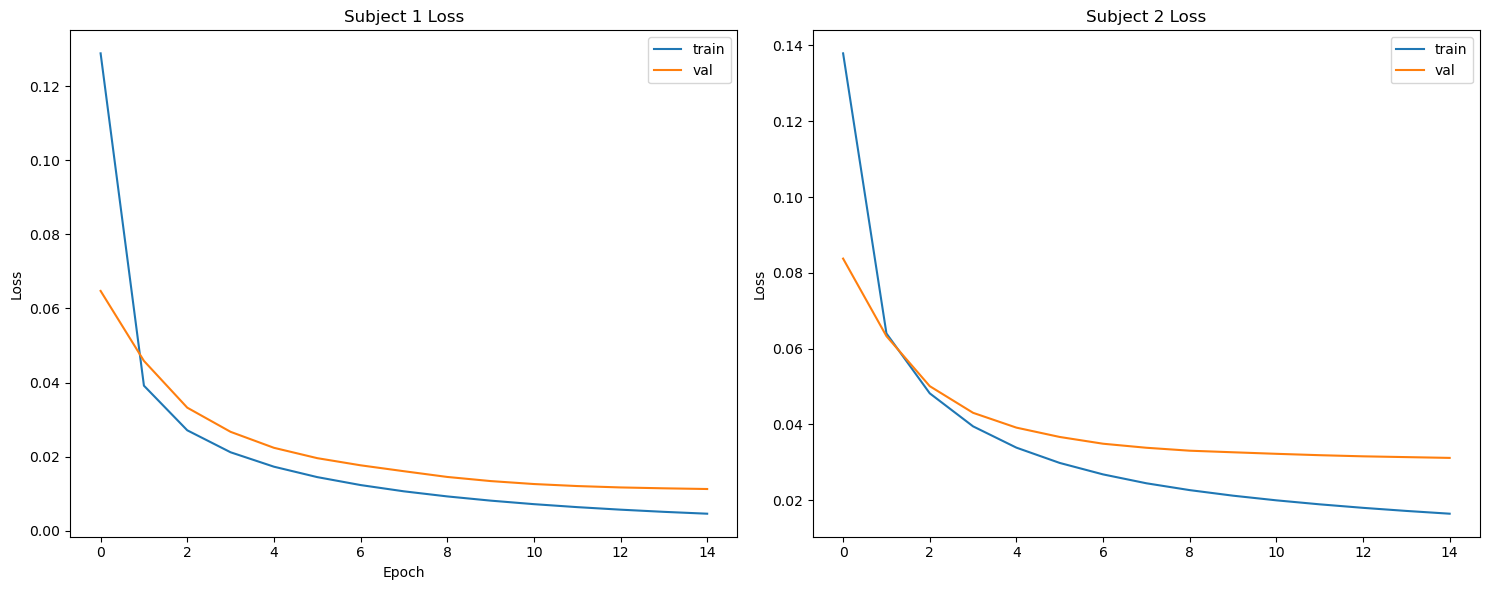

In [109]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

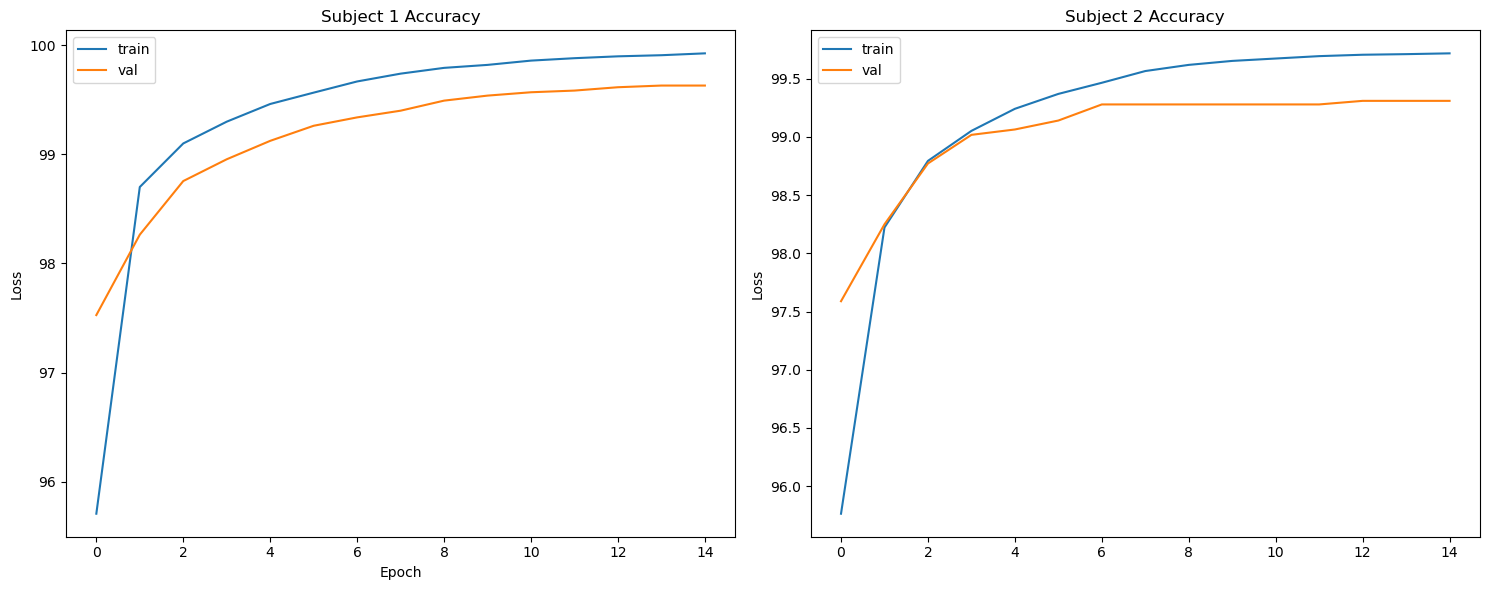

In [110]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [111]:
input_dim = 1
n_classes = 7
input_height = 50
input_width = 8
n_conv_layers = 3
conv_kernel_size = [3, 3, 3]
n_filters = [32, 64, 128]
pool_kernel_size = (2, 1)

print('Training on Subject 1')
print('=====================')
model1 = CNN(input_dim, n_classes, input_height, input_width,
             n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters, pool_kernel_size=pool_kernel_size)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0., weight_decay=0.)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = CNN(input_dim, n_classes, input_height, input_width,
             n_conv_layers=n_conv_layers, conv_kernel_size=conv_kernel_size, n_filters=n_filters, pool_kernel_size=pool_kernel_size)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0., weight_decay=0.)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 91.33%, Validation Accuracy: 95.13%, Epoch Time: 3833.2579ms
Epoch [2/15], Train Accuracy: 96.02%, Validation Accuracy: 96.53%, Epoch Time: 3777.4930ms
Epoch [3/15], Train Accuracy: 96.87%, Validation Accuracy: 97.00%, Epoch Time: 3796.4001ms
Epoch [4/15], Train Accuracy: 97.28%, Validation Accuracy: 97.42%, Epoch Time: 3783.9770ms
Epoch [5/15], Train Accuracy: 97.60%, Validation Accuracy: 97.60%, Epoch Time: 3779.1860ms
Epoch [6/15], Train Accuracy: 97.85%, Validation Accuracy: 97.88%, Epoch Time: 3818.9571ms
Epoch [7/15], Train Accuracy: 98.05%, Validation Accuracy: 98.05%, Epoch Time: 3790.5061ms
Epoch [8/15], Train Accuracy: 98.26%, Validation Accuracy: 98.25%, Epoch Time: 3799.8099ms
Epoch [9/15], Train Accuracy: 98.41%, Validation Accuracy: 98.42%, Epoch Time: 3768.1479ms
Epoch [10/15], Train Accuracy: 98.54%, Validation Accuracy: 98.57%, Epoch Time: 3797.9989ms
Epoch [11/15], Train Accuracy: 98.66%, Validation Accuracy: 98.68%,

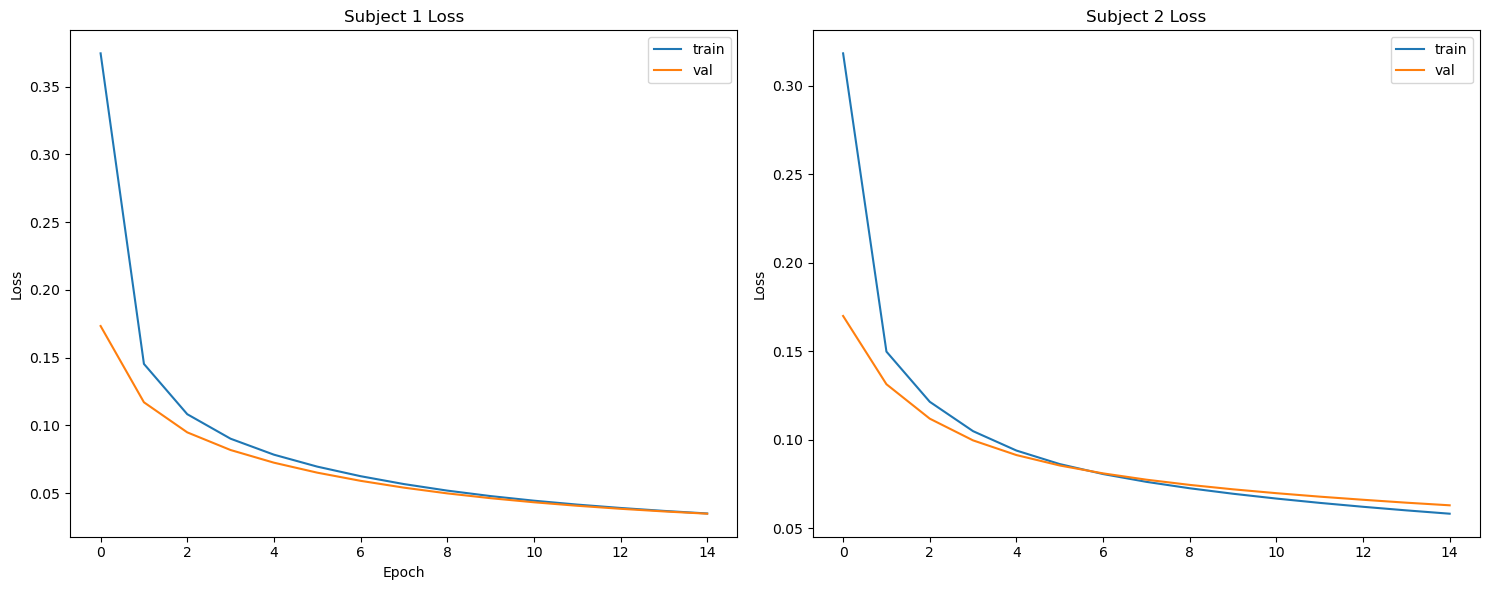

In [112]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

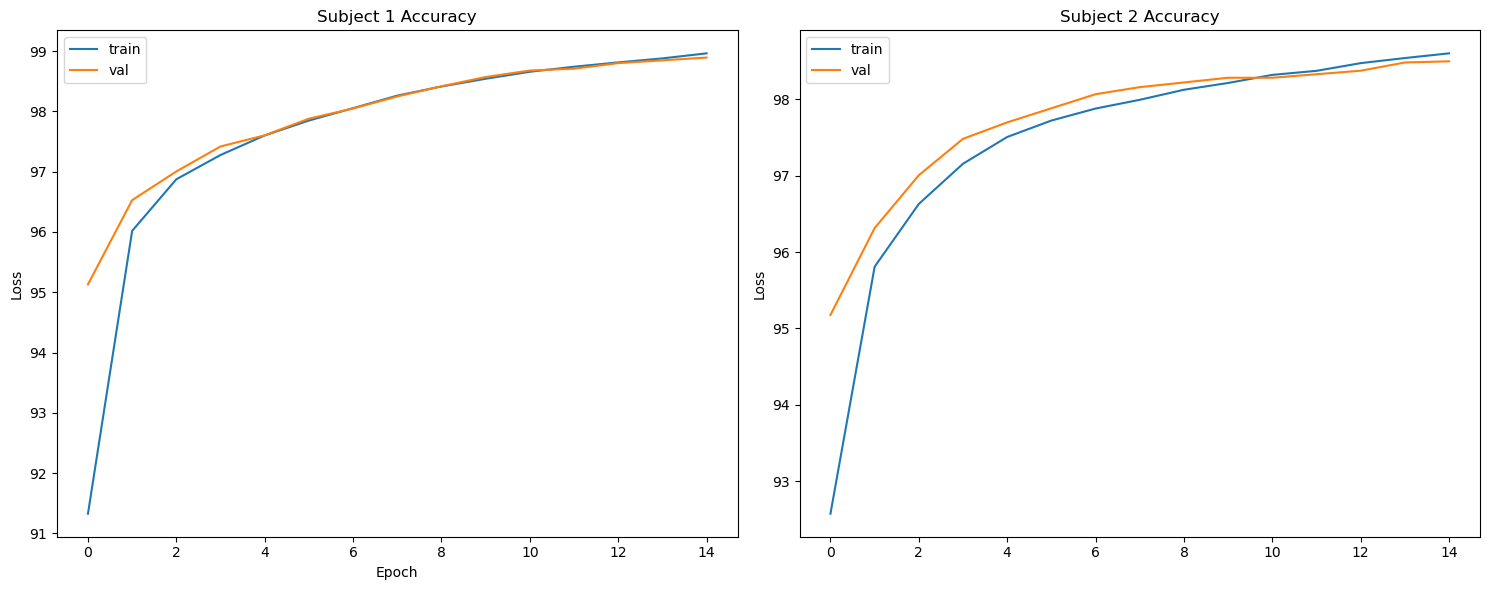

In [113]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Hyperparameters: Batch=128

In [391]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, batch_size=128)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 1960.4609ms | Accuracy 94.01%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 1606.7069ms | Accuracy 94.93%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 1641.9451ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 1611.0551ms | Accuracy 92.63%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 1609.0610ms | Accuracy 99.08%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 1657.3050ms | Accuracy 81.57%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 1650.1031ms | Accuracy 89.40%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1658.0062m

### Hyperparameters: Batch=256

In [392]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, batch_size=256)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 1255.8949ms | Accuracy 93.55%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 1016.6609ms | Accuracy 92.17%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 1011.4012ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 1011.8673ms | Accuracy 92.17%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 1019.4390ms | Accuracy 91.71%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 1051.8389ms | Accuracy 82.03%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 1036.1619ms | Accuracy 82.03%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1010.9179ms

### Hyperparameters: Batch=64

In [394]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, batch_size=64)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 2782.3889ms | Accuracy 95.39%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 2629.8091ms | Accuracy 96.77%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 2704.6640ms | Accuracy 96.31%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 2702.2483ms | Accuracy 92.17%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 2641.2759ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 2958.1850ms | Accuracy 86.64%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 2771.3258ms | Accuracy 94.93%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 2743.5369m

### Hyperparameters: Epoch=25

In [396]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4079.5081ms | Accuracy 97.70%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4334.5871ms | Accuracy 95.85%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 3865.4430ms | Accuracy 99.54%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4514.3712ms | Accuracy 94.93%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4403.1019ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4415.7250ms | Accuracy 87.56%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4607.6579ms | Accuracy 94.01%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4537.2770m

### Hyperparameters: Epoch=30

In [431]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=35)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 5881.9757ms | Accuracy 98.16%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 5856.2660ms | Accuracy 96.31%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 5928.5078ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 6036.6230ms | Accuracy 95.39%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 5980.7239ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 5967.0331ms | Accuracy 88.48%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 5970.2730ms | Accuracy 94.47%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 5961.4909

In [463]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=40)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 7457.7630ms | Accuracy 98.16%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 6813.6179ms | Accuracy 96.77%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 6947.4652ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 6807.5328ms | Accuracy 96.77%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 7006.8772ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 6834.6860ms | Accuracy 88.94%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 6915.0741ms | Accuracy 93.55%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 6914.0270

In [430]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=45)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 7728.4510ms | Accuracy 98.62%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 7551.3141ms | Accuracy 97.24%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 7630.9078ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 7737.6480ms | Accuracy 95.85%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 7483.5341ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 7592.4220ms | Accuracy 88.94%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 7540.3130ms | Accuracy 94.47%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 7656.2521m

In [432]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 8526.7920ms | Accuracy 98.62%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 8502.3010ms | Accuracy 97.70%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 8349.6239ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 8445.1599ms | Accuracy 96.77%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 8495.6050ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 8279.3858ms | Accuracy 91.24%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 8524.5519ms | Accuracy 94.93%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 8386.8699m

### Hyperparameters: Epoch=50

In [397]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=50)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 9062.1531ms | Accuracy 98.62%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 9226.0642ms | Accuracy 98.16%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 8885.0858ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 8860.6980ms | Accuracy 94.47%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 9058.5222ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 8960.9809ms | Accuracy 90.32%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 8902.1981ms | Accuracy 95.85%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 8795.6271

### Hyperparameters: Epochs=75

In [398]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=75)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 13942.9519ms | Accuracy 99.08%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 14085.4802ms | Accuracy 98.16%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 13745.8580ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 14119.2303ms | Accuracy 98.16%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 14015.8231ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 13569.6621ms | Accuracy 90.78%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 14260.0667ms | Accuracy 81.11%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 139

### Hyperparameters: Momentum=0.99

Epoch 50

In [400]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.99, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 8991.3812ms | Accuracy 96.77%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 9079.1781ms | Accuracy 97.70%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 8965.3981ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 9263.7591ms | Accuracy 97.70%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 9231.4110ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 9113.6661ms | Accuracy 88.48%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 9370.8189ms | Accuracy 93.09%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 9120.0001m

Epoch 25

In [402]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.99, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4396.7180ms | Accuracy 95.39%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4491.3270ms | Accuracy 97.24%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4432.6608ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4286.1021ms | Accuracy 94.93%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4418.5052ms | Accuracy 99.08%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4409.8368ms | Accuracy 84.33%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4317.4648ms | Accuracy 93.09%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4202.7600ms

Epoch 15

In [401]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.99, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 2750.5491ms | Accuracy 94.47%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 2687.6278ms | Accuracy 94.93%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 2581.2564ms | Accuracy 90.78%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 2803.2901ms | Accuracy 95.39%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 2730.2830ms | Accuracy 91.24%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 2731.6380ms | Accuracy 84.79%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 2746.9220ms | Accuracy 87.10%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 2761.4903ms

### Hyperparameters: Momentum=0.95

Epoch 50

In [403]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.95, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 8916.4701ms | Accuracy 99.08%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 8816.1831ms | Accuracy 98.62%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 8570.5988ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 8958.7049ms | Accuracy 97.70%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 8956.8930ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 8969.6372ms | Accuracy 93.09%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 9325.0120ms | Accuracy 71.89%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 9483.2551

Epoch 25

In [404]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.95, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4499.6121ms | Accuracy 96.77%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4424.2203ms | Accuracy 98.62%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4455.3621ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4582.9530ms | Accuracy 81.11%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4428.6509ms | Accuracy 99.54%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4556.0341ms | Accuracy 87.10%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4426.8243ms | Accuracy 94.47%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4619.9379ms

Epoch 15

In [406]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.95, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 2563.7860ms | Accuracy 95.39%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 2701.2551ms | Accuracy 97.70%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 2765.2953ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 2783.6938ms | Accuracy 82.49%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 2667.0191ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 2623.8930ms | Accuracy 75.12%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 2664.3803ms | Accuracy 85.25%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 2751.8940

### Hyperparameters: Momentum=0.8

Epoch 15

In [407]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.8, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 2610.7109ms | Accuracy 92.63%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 2707.0830ms | Accuracy 80.18%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 2573.4608ms | Accuracy 98.16%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 2846.5610ms | Accuracy 70.97%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 2567.2419ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 2618.2930ms | Accuracy 84.79%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 2785.3498ms | Accuracy 84.79%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 2665.6971m

Epoch 25

In [408]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.8, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 4361.5570ms | Accuracy 94.47%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 4380.4181ms | Accuracy 94.01%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 4553.3471ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 4434.9730ms | Accuracy 93.55%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4354.3038ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 4345.6049ms | Accuracy 87.56%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 4505.3349ms | Accuracy 91.24%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 4413.2402m

Epoch 50

In [409]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.8, 0.999))
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 8692.6250ms | Accuracy 97.70%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 8962.0659ms | Accuracy 96.77%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 8812.3999ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 8971.3218ms | Accuracy 97.24%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 8562.8228ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 8817.6589ms | Accuracy 88.94%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 8970.8910ms | Accuracy 92.17%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 8917.7022m

In [148]:
print('Training on Subject 1')
print('=====================')
model1 = CNN()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.1, momentum=0.6, weight_decay=0.)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = CNN()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.1, momentum=0.6, weight_decay=0.)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 96.50%, Validation Accuracy: 98.76%, Epoch Time: 8101.1608ms
Epoch [2/15], Train Accuracy: 98.86%, Validation Accuracy: 98.56%, Epoch Time: 7589.5422ms
Epoch [3/15], Train Accuracy: 99.09%, Validation Accuracy: 98.69%, Epoch Time: 7066.9808ms
Epoch [4/15], Train Accuracy: 99.29%, Validation Accuracy: 98.22%, Epoch Time: 7398.3240ms
Epoch [5/15], Train Accuracy: 99.42%, Validation Accuracy: 98.03%, Epoch Time: 6970.8862ms
Epoch [6/15], Train Accuracy: 99.50%, Validation Accuracy: 98.57%, Epoch Time: 7544.7612ms
Epoch [7/15], Train Accuracy: 99.61%, Validation Accuracy: 98.99%, Epoch Time: 7285.0161ms
Epoch [8/15], Train Accuracy: 99.69%, Validation Accuracy: 98.51%, Epoch Time: 7453.9812ms
Epoch [9/15], Train Accuracy: 99.66%, Validation Accuracy: 99.43%, Epoch Time: 7574.8539ms
Epoch [10/15], Train Accuracy: 99.72%, Validation Accuracy: 99.29%, Epoch Time: 7552.1381ms
Epoch [11/15], Train Accuracy: 99.79%, Validation Accuracy: 99.39%,

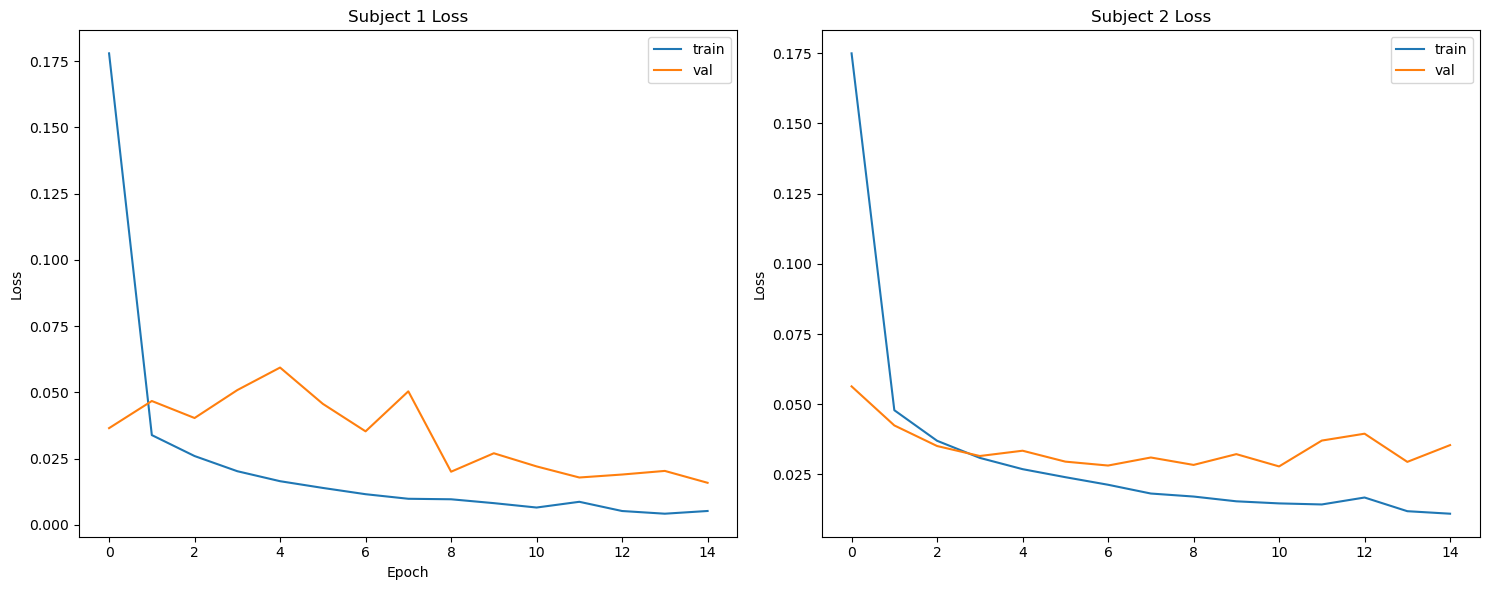

In [149]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

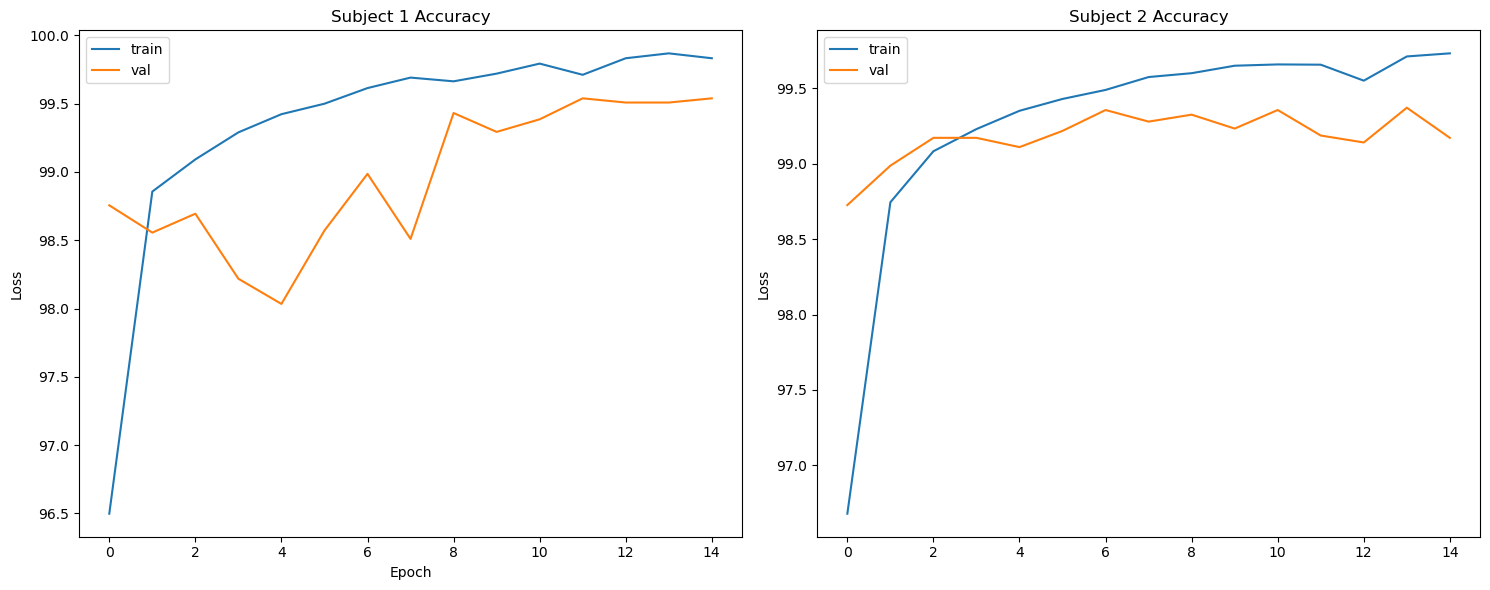

In [150]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Hyperparameters: Decay=0.1

Epoch 50

In [410]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 11255.0521ms | Accuracy 98.62%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 10942.6088ms | Accuracy 91.71%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 10582.0432ms | Accuracy 97.24%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 10586.0629ms | Accuracy 84.79%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 10987.5960ms | Accuracy 99.54%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 10328.7249ms | Accuracy 86.64%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 10528.6100ms | Accuracy 95.39%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 1085

Epoch 25

In [411]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 5662.6470ms | Accuracy 97.70%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 5359.6261ms | Accuracy 83.87%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 5564.9719ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 5690.5370ms | Accuracy 67.74%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 5438.3950ms | Accuracy 96.77%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 5618.2001ms | Accuracy 88.48%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 5628.9771ms | Accuracy 53.00%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 5890.0633ms

Epoch 15

In [412]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 3397.2211ms | Accuracy 96.31%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 3410.5740ms | Accuracy 94.47%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 3302.1250ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 3511.1401ms | Accuracy 86.64%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 3273.9997ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 3219.1417ms | Accuracy 81.57%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 3387.2321ms | Accuracy 92.17%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 3450.1619m

### Hyperparameters: Decay=0.01

Epoch 15

In [413]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 3281.6410ms | Accuracy 95.39%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 3124.3839ms | Accuracy 94.93%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 3297.5609ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 3180.3758ms | Accuracy 93.09%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 3203.1369ms | Accuracy 99.54%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 3073.0088ms | Accuracy 86.64%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 3181.1819ms | Accuracy 92.63%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 3337.9529m

Epoch 25

In [416]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 5095.2680ms | Accuracy 97.70%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 5363.4958ms | Accuracy 97.24%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 5305.0501ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 5592.6208ms | Accuracy 94.47%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 5514.9729ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 5560.7250ms | Accuracy 88.02%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 5368.8769ms | Accuracy 94.93%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 5489.9020m

Epoch 50

In [417]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 10932.1039ms | Accuracy 98.62%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 10917.7940ms | Accuracy 97.24%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 10812.3541ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 11368.0990ms | Accuracy 94.47%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 11349.7128ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 11270.1530ms | Accuracy 88.94%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 11502.5651ms | Accuracy 95.39%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 11

### Hyperparameters: Decay=0.001

Epoch 15

In [418]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 3135.5138ms | Accuracy 95.39%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 3255.1749ms | Accuracy 96.77%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 3084.6550ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 3413.5950ms | Accuracy 89.86%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 2979.1679ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 3245.6310ms | Accuracy 85.71%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 3243.2029ms | Accuracy 92.63%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 3084.3959

Epoch 25

In [419]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 5299.6590ms | Accuracy 97.70%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 5285.4691ms | Accuracy 95.85%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 5423.3441ms | Accuracy 99.54%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 5280.1991ms | Accuracy 95.39%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 5270.5140ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 5242.4629ms | Accuracy 88.48%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 5268.0249ms | Accuracy 94.01%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 5274.5309m

Epoch 50

In [420]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 10663.1322ms | Accuracy 98.62%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 10569.3731ms | Accuracy 95.85%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 10280.0491ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 10293.7589ms | Accuracy 96.31%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 10840.8220ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 10960.8650ms | Accuracy 89.40%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 10491.2889ms | Accuracy 94.47%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 103

### Hyperparameters: Decay=0.0001

Epoch 15

In [421]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 3419.0068ms | Accuracy 94.93%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 3048.5551ms | Accuracy 96.31%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 3009.5990ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 3091.2752ms | Accuracy 90.78%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 3106.8561ms | Accuracy 99.54%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 3190.3999ms | Accuracy 85.25%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 3115.7870ms | Accuracy 94.01%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 3216.1009m

Epoch 25

In [422]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 5372.6580ms | Accuracy 99.08%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 5481.3709ms | Accuracy 96.31%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 5377.7401ms | Accuracy 100.00%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 5358.0348ms | Accuracy 94.01%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 5212.6441ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 5423.5532ms | Accuracy 89.86%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 5123.1511ms | Accuracy 92.63%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 5111.4590

Epoch 50

In [423]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 10625.5980ms | Accuracy 98.62%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 10419.1353ms | Accuracy 98.16%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 10685.9651ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 10826.9560ms | Accuracy 96.77%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 10744.5319ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 10482.4650ms | Accuracy 88.94%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 10532.3761ms | Accuracy 94.47%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 105

### Hyperparameters: Decay=0.00001

Epoch 15

In [424]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=15)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 3180.6331ms | Accuracy 98.16%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 3359.9980ms | Accuracy 94.93%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 2994.9408ms | Accuracy 98.62%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 3310.0684ms | Accuracy 94.93%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 3275.6548ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 3209.4657ms | Accuracy 85.25%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 3232.6729ms | Accuracy 93.09%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 3263.4618m

Epoch 25

In [425]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False, num_epochs=25)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 5403.7149ms | Accuracy 96.77%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 5414.8540ms | Accuracy 95.85%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 5044.5189ms | Accuracy 99.08%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 5243.7413ms | Accuracy 95.85%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 4810.9930ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 5164.6059ms | Accuracy 86.64%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 5598.7639ms | Accuracy 92.63%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 5469.7850m

Epoch 50

In [426]:
accuracies = list()

for i, (sub, day, sess, rep) in enumerate(picked_combination):
    print(f'Start training on combination {i + 1}')
    start_time = time.time()
    df_train = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition != rep)]
    df_test = df[(df.subject == sub) & (df.day == day) & (df.session == sess) & (df.repetition == rep)]

    # Build training and test data
    train_set, val_set = prepare_training(df_train, df_test)

    # Prepare training
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
    model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                criterion, optimizer, verbose=False)
    acc = val_acc[-1]
    
    accuracies.append(acc)
    comb_time = (time.time() - start_time) * 1e3 # in milisecond
    print(f'Subject {sub} | Day {day} | Session {sess} | Test Repetition {rep} | Time : {comb_time:.4f}ms | Accuracy {acc:.2f}%')

print(f'Mean Accuracies: {np.mean(accuracies)}')

Start training on combination 1
Subject sub02 | Day D8 | Session S2 | Test Repetition 7 | Time : 10540.9112ms | Accuracy 98.62%
Start training on combination 2
Subject sub01 | Day D6 | Session S1 | Test Repetition 3 | Time : 10613.3361ms | Accuracy 97.24%
Start training on combination 3
Subject sub04 | Day D12 | Session S1 | Test Repetition 7 | Time : 10653.5051ms | Accuracy 99.54%
Start training on combination 4
Subject sub04 | Day D6 | Session S1 | Test Repetition 4 | Time : 10518.9700ms | Accuracy 97.24%
Start training on combination 5
Subject sub04 | Day D1 | Session S2 | Test Repetition 5 | Time : 10399.9002ms | Accuracy 100.00%
Start training on combination 6
Subject sub02 | Day D14 | Session S2 | Test Repetition 2 | Time : 10504.4849ms | Accuracy 90.32%
Start training on combination 7
Subject sub02 | Day D6 | Session S2 | Test Repetition 10 | Time : 10531.7121ms | Accuracy 94.93%
Start training on combination 8
Subject sub02 | Day D3 | Session S2 | Test Repetition 7 | Time : 108

## Model Evaluation

In [12]:
subjects = ['sub0' + str(i) for i in range(1, 8)]
days = ['D' + str(i) for i in range(1, 16)]
sessions = ['S1', 'S2']

### Within-Session Analysis

In [460]:
a = df[(df.subject == 'sub01') & (df.day == 'D1') & (df.session == 'S1') & (df.repetition != 10)]
b = df[(df.subject == 'sub01') & (df.day == 'D1') & (df.session == 'S2') & (df.repetition == 10)]

In [461]:
a_set, b_set = prepare_training(a, b)

In [462]:
m = CNN(n_conv_layers=2, n_filters=[32, 64], conv_kernel_size=[7,7])
c = nn.CrossEntropyLoss()
o = optim.Adam(m.parameters(), lr=0.0001)
m, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(m, a_set, b_set, c, o, verbose=True)

Epoch [1/50], Train Accuracy: 10.70%, Validation Accuracy: 14.29%, Epoch Time: 244.5960ms
Epoch [2/50], Train Accuracy: 0.05%, Validation Accuracy: 25.81%, Epoch Time: 170.9130ms
Epoch [3/50], Train Accuracy: 10.50%, Validation Accuracy: 52.07%, Epoch Time: 171.3998ms
Epoch [4/50], Train Accuracy: 21.61%, Validation Accuracy: 54.38%, Epoch Time: 170.3110ms
Epoch [5/50], Train Accuracy: 30.11%, Validation Accuracy: 55.76%, Epoch Time: 174.4940ms
Epoch [6/50], Train Accuracy: 36.15%, Validation Accuracy: 58.53%, Epoch Time: 171.2952ms
Epoch [7/50], Train Accuracy: 42.19%, Validation Accuracy: 60.83%, Epoch Time: 175.1969ms
Epoch [8/50], Train Accuracy: 49.26%, Validation Accuracy: 61.75%, Epoch Time: 171.9379ms
Epoch [9/50], Train Accuracy: 54.12%, Validation Accuracy: 63.59%, Epoch Time: 173.3041ms
Epoch [10/50], Train Accuracy: 58.47%, Validation Accuracy: 64.98%, Epoch Time: 170.5418ms
Epoch [11/50], Train Accuracy: 62.42%, Validation Accuracy: 66.36%, Epoch Time: 172.3998ms
Epoch [12

In [15]:
ws_df = pd.DataFrame(columns=['subject', 'day', 'session', 'performance_cv', 'train_time', 'inference_time'])

# Analyse for each subject
for sub in tqdm(subjects):
    sub_df = df[df.subject == sub]
    
    # Analyse each session in each day
    for day in tqdm(days):
        day_df = sub_df[sub_df.day == day]

        for sess in sessions:
            sess_df = day_df[day_df.session == sess]
            accuracies = list()
            train_times = list()
            inf_times = list()
            
            # Cross-validate 10 folds for each session
            for i in range(1, 11):
                # Devide test and train dataset
                train_df = sess_df[sess_df.repetition != i]
                test_df = sess_df[sess_df.repetition == i]

                # Set up dataset
                train_set, val_set = prepare_training(train_df, test_df)

                # Train Classifier
                model = CNN()
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                            criterion, optimizer, verbose=False)
                train_times.append(ttime) # average across all epochs
                inf_times.append(itime) # average across all epochs
                accuracies.append(val_acc[-1])

            ws_df.loc[len(ws_df)] = [sub, day, sess, accuracies, train_times, inf_times]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [5:12:51<00:00, 2681.65s/it]


In [16]:
ws_df['session_mean'] = ws_df.performance_cv.apply(lambda x: np.mean(x))
ws_df['train_time_mean'] = ws_df.train_time.apply(lambda x: np.mean(x))
ws_df['inference_time_mean'] = ws_df.inference_time.apply(lambda x: np.mean(x))

In [17]:
ws_df.head()

,subject,day,session,performance_cv,train_time,inference_time,session_mean,train_time_mean,inference_time_mean
0,sub01,D1,S1,"[98.61751152073732, 95.85253456221199, 96.3133...","[164045.60089111328, 156703.89652252197, 14022...","[14796.929359436035, 13907.747268676758, 12329...",95.944700,157776.771069,14036.392212
1,sub01,D1,S2,"[87.09677419354838, 95.39170506912443, 98.1566...","[158583.8794708252, 157756.55269622803, 162082...","[14068.207740783691, 13732.128143310547, 14235...",96.451613,162524.796963,14523.462296
2,sub01,D2,S1,"[84.7926267281106, 95.39170506912443, 92.62672...","[151022.1290588379, 160069.7946548462, 158197....","[12967.004776000977, 13997.015953063965, 13962...",94.838710,155651.203632,13553.789616
3,sub01,D2,S2,"[83.87096774193549, 99.07834101382488, 96.7741...","[152808.23707580566, 153403.058052063, 166058....","[13374.218940734863, 13723.98853302002, 14850....",96.405530,158464.242935,14055.709362
4,sub01,D3,S1,"[86.63594470046083, 95.39170506912443, 98.1566...","[157040.82489013672, 153625.84114074707, 15667...","[14241.094589233398, 13903.393745422363, 13787...",94.838710,168766.372204,15195.502281


In [18]:
ws_df.shape

(210, 9)

In [303]:
ws_df[(ws_df.subject == 'sub01') & (ws_df.day == 'D9')].session_mean.mean()

82.48847926267283

In [19]:
ws_df.session_mean.mean()

92.633091946456

In [20]:
print(ws_df.train_time_mean.mean(), ws_df.inference_time_mean.mean())

164207.44624137878 14312.505597159976


In [22]:
# Save dataframe
file = open('./analysis/cnn-2/within-session-cnn-3.pkl', 'wb')
pickle.dump(ws_df, file)
file.close()